# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


# Data Exploration

In [3]:
base_path = 'dataset/'
train_dir=os.path.join(base_path, 'train')
diseases = os.listdir(train_dir)

label = []
for dis in diseases:
    label.append(dis)

In [4]:
label

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

# Transfer Learning MobileNetV3Large

In [5]:
labels = os.listdir('dataset/train/')
print(train_dir)
img_size = 256

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.2,
    subset='training',
    seed=12
)


val_dataset = image_dataset_from_directory(
    train_dir,
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.2,
    subset='validation',
    seed=12
)

dataset/train
Found 8323 files belonging to 10 classes.
Using 6659 files for training.
Found 8323 files belonging to 10 classes.
Using 1664 files for validation.


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def get_model(base, preprocessor, img_size):    
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = preprocessing.Rescaling(1./255)(inputs)
    x = preprocessing.RandomFlip('horizontal')(inputs)
    x = preprocessing.RandomFlip('vertical')(x)
    x = preprocessing.RandomRotation(factor=0.4, fill_mode="wrap")(x)
    x = preprocessing.RandomContrast(factor=0.2)(x)
    x = preprocessor(x)
    x = base(x)

    x = tfl.Flatten()(x)
    x = tfl.Dense(1024, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.Dropout(0.15)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

pre_trained_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')

pre_trained_model.trainable = False

In [9]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath='model.weights.best.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [10]:
model = get_model(pre_trained_model, preprocess_input, img_size)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        299635

In [12]:
hist = model.fit(train_dataset,
                 validation_data=val_dataset,
                 epochs=50,
                 verbose=1,
                 callbacks=[early_stop, lr_reduction, checkpoint])

Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: 1.8175 - accuracy: 0.4047
Epoch 1: val_loss improved from inf to 1.74176, saving model to model.weights.best.hdf5
105/105 [==============================] - 382s 3s/step - loss: 1.8175 - accuracy: 0.4047 - val_loss: 1.7418 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 1.2799 - accuracy: 0.5774
Epoch 2: val_loss improved from 1.74176 to 1.11599, saving model to model.weights.best.hdf5
105/105 [==============================] - 359s 3s/step - loss: 1.2799 - accuracy: 0.5774 - val_loss: 1.1160 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.6707
Epoch 3: val_loss did not improve from 1.11599
105/105 [==============================] - 354s 3s/step - loss: 1.0356 - accuracy: 0.6707 - val_loss: 1.2026 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 4/50
105/105 [==============================

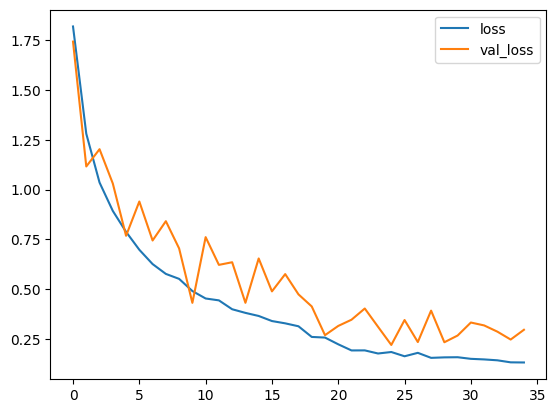

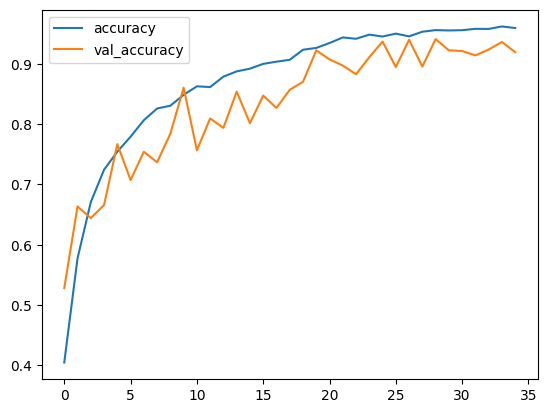

In [13]:
hist = pd.DataFrame(hist.history)
hist.loc[:,['loss','val_loss']].plot()
hist.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

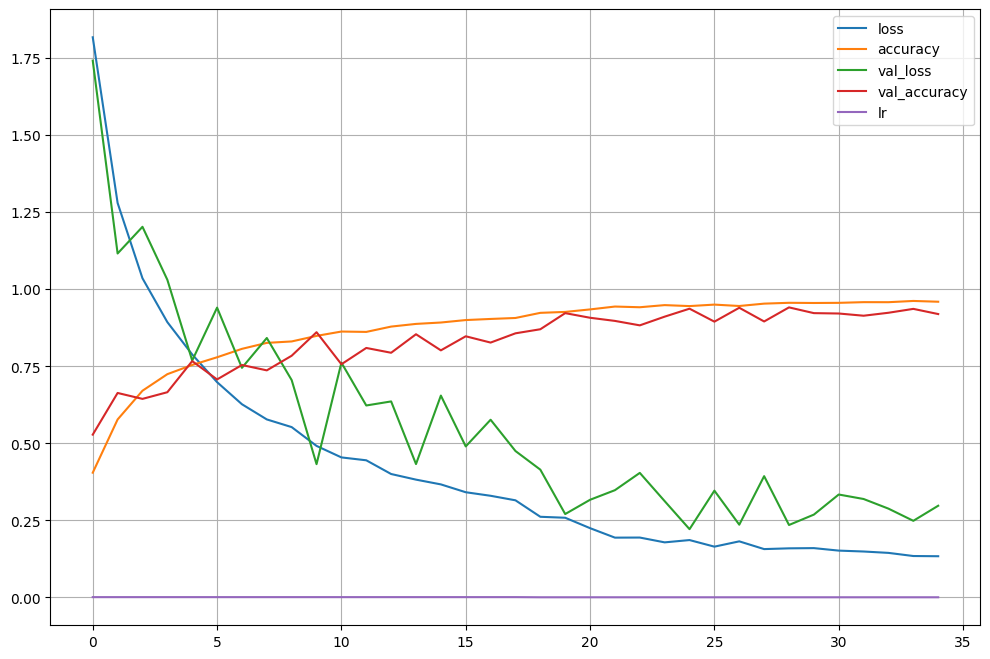

In [14]:
hist.plot(figsize = (12,8))

plt.grid(True)

# Save Model

In [ ]:
model.save('worldcapstone2.h5')

In [17]:
model_version = "1"
model_save = "harvestia"
model_path = os.path.join(model_save, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: harvestia\1\assets


INFO:tensorflow:Assets written to: harvestia\1\assets


# Convert to TFLite

In [ ]:
model_new = tf.keras.models.load_model('worldcapstone2.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_new)
tflite_model = converter.convert()

with open("capstone2.tflite", "wb") as f:
  f.write(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_new)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open("harvestia.tflite", "wb") as f:
    f.write(tflite_quant_model)